# Formation Energy Prediction using *Ward 2016* Method

This notebook uses the method from [Ward 2016](https://www.nature.com/articles/npjcompumats201628) to predict formation energy of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
training_file = "datasets/oqmd_groundstate.data"
delimiter = ' '
comp_col = "comp"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~300000 compounds with data extracted from the Open Quantum Materials Database (OQMD)

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
        
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))

    return training_set

training_set = load_training_set(training_file, delimiter)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Create PyMatGen Composition objects

In [4]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)

training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
0,Pd1,-5.158533,15.20880,None,0.0,0.018186,0.0181856433333,True,(Pd)
1,Hf1,-9.923202,22.36760,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf)
2,In1,-2.714826,26.81600,None,0.0,0.005113,0.00511323666667,True,(In)
3,Mo1,-10.419117,15.92040,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo)
4,Nb1,-9.800921,18.67330,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb)
5,Ni1,-5.552162,10.70220,0.611777266667,0.0,0.014457,0.01445706,True,(Ni)
6,Os1,-11.181135,14.28270,7.71e-05,0.0,0.044841,0.04484125,True,(Os)
7,Pb1,-3.692987,31.17950,None,0.0,0.010978,0.0109780066667,True,(Pb)
8,Pm1,-4.741485,34.23060,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm)
9,Pr1,-4.768796,35.98410,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr)


## Compute descriptors using MatMiner
Here, we compute 145 composition based attributes as described in *Ward 2016* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [5]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.Stoichiometry().featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElementProperty().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbital().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.IonProperty().featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

#%lprun -f calc_attributes calc_attributes()

all_descriptors, attr_names = calc_attributes(training_set)
print np.shape(all_descriptors)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


(228676, 158)
CPU times: user 18min 37s, sys: 6.85 s, total: 18min 44s
Wall time: 20min 23s


## Predicting formation energy

In [6]:
#Drop NaN values from training set

training_set_use = all_descriptors.replace("None", np.nan)
training_set_use = training_set_use.replace(np.inf, np.nan)
training_set_use = training_set_use.dropna()

training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj,0-norm,...,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons,Avg Ionic Char,Max Ionic Char,compound possible
0,Pd1,-5.158533,15.20880,None,0.0,0.018186,0.0181856433333,True,(Pd),1.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,Hf1,-9.923202,22.36760,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf),1.0,...,14.000000,0.000000,2.000000,0.111111,0.777778,0.000000,0.111111,0.000000,0.000000,1.0
2,In1,-2.714826,26.81600,None,0.0,0.005113,0.00511323666667,True,(In),1.0,...,0.000000,1.000000,2.000000,0.769231,0.000000,0.076923,0.153846,0.000000,0.000000,1.0
3,Mo1,-10.419117,15.92040,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo),1.0,...,0.000000,0.000000,1.000000,0.833333,0.000000,0.000000,0.166667,0.000000,0.000000,1.0
4,Nb1,-9.800921,18.67330,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb),1.0,...,0.000000,0.000000,1.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,1.0
5,Ni1,-5.552162,10.70220,0.611777266667,0.0,0.014457,0.01445706,True,(Ni),1.0,...,0.000000,0.000000,2.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,1.0
6,Os1,-11.181135,14.28270,7.71e-05,0.0,0.044841,0.04484125,True,(Os),1.0,...,14.000000,0.000000,2.000000,0.272727,0.636364,0.000000,0.090909,0.000000,0.000000,1.0
7,Pb1,-3.692987,31.17950,None,0.0,0.010978,0.0109780066667,True,(Pb),1.0,...,14.000000,2.000000,2.000000,0.357143,0.500000,0.071429,0.071429,0.000000,0.000000,1.0
8,Pm1,-4.741485,34.23060,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm),1.0,...,5.000000,0.000000,2.000000,0.000000,0.714286,0.000000,0.285714,0.000000,0.000000,1.0
9,Pr1,-4.768796,35.98410,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr),1.0,...,3.000000,0.000000,2.000000,0.000000,0.600000,0.000000,0.400000,0.000000,0.000000,1.0


In [7]:
#Discretize into positive/negative formation energy

delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['p' 'p' 'p' ..., 'n' 'n' 'n']


In [8]:
#Random Forest Classifier

model1 = RandomForestClassifier(n_estimators=8, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [9]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,92266,126
p,580,135701


In [10]:
#Decision Trees Classifier

model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], energy_range)
prediction = model2.predict(training_set_use[attr_names])

In [11]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,92392,0
p,0,136281


In [12]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
prediction = rf_model.predict(training_set_use[attr_names])

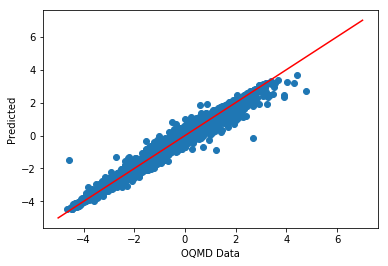

In [14]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [15]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.161793981462
CPU times: user 23min 22s, sys: 6.32 s, total: 23min 28s
Wall time: 23min 34s


### Decision Tree

In [16]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [17]:
prediction = dt_model.predict(training_set_use[attr_names])

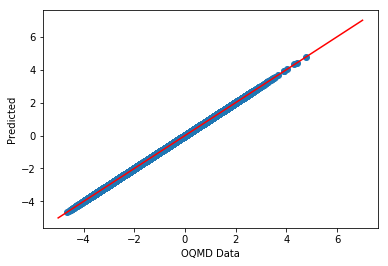

In [18]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [19]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.214945964344
CPU times: user 3min 13s, sys: 2.2 s, total: 3min 15s
Wall time: 3min 16s
